# Sumarização de textos longos de forma iterativa

ref.: https://python.langchain.com/docs/how_to/summarize_refine/

In [1]:
from langchain_ollama import ChatOllama
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.runnables import RunnableConfig

import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from IPython.display import Image
from IPython.display import display, Markdown

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Utilização do llama3.2 com interface via ollama

In [2]:
# Inicialize o modelo ChatOllama
llm = ChatOllama(
    model="llama3.2",
    temperature=0.1)

In [3]:
# Função para ler o conteúdo de um arquivo .txt
def load_text_from_file(file_path: str) -> List[Document]:
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return [Document(page_content=content)]

# Carrega o arquivo .txt
docs = load_text_from_file("./memorias_postumas_bras_cubas.txt")
len(docs[0].page_content)

359460

In [4]:
type(docs[0])

langchain_core.documents.base.Document

In [5]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=10_000, chunk_overlap=100
)
documents  = text_splitter.split_documents(docs)
print(f"Generated {len(documents)} documents.")

Generated 15 documents.


In [6]:
documents[0].page_content[:1000]

'AO LEITOR\nQue, no alto do principal de seus livros, confessasse Stendhal havel-o escripto para cem leitores, cousa é que admira e consterna. O que não admira, nem provavelmente consternará é se este outro livro não tiver os cem leitores de Stendhal, nem cincoenta, nem vinte, e quando muito, dez. Dez? Talvez cinco. Trata-se, na verdade, de uma obra diffusa, na qual eu, Braz Cubas, se adoptei a fórma livre de um Sterne, de um Lamb, ou de um de Maistre, não sei se lhe metti algumas rabugens de pessimismo. Póde ser. Obra de finado. Escrevi-a com a penna da galhofa e a tinta da melancholia; e não é difficil antever o que poderá sair desse connubio. Accresce que a gente grave achará no livro umas apparencias de puro romance, ao passo que a gente frivola não achará nelle o seu romance usual; e eil-o ahi fica privado da estima dos graves e do amor dos frivolos, que são as duas columnas maximas da opinião.\n\nMas eu ainda espero angariar as sympatias da opinião, e o meio efficaz para isso é f

In [7]:
# Initial summary
initial_prompt = """
Leia o seguinte trecho de um livro em português e faça um resumo claro e objetivo. No resumo:

1. Descreva apenas os personagens principais que aparecem nos resumos, detalhando seus papéis na história, sem fazer suposições além do que é mencionado.
2. Apresente de maneira simples o enredo, explicando os principais acontecimentos descritos nos resumos, de forma organizada e sequencial.
3. Use uma linguagem acessível, para que mesmo uma pessoa leiga possa entender do que se trata a história.
4. Consolide os principais temas e eventos abordados nos resumos, organizando-os em uma narrativa coesa e fluida.
5. Evite mencionar informações que não estejam presentes no trecho ou conclusões sobre a trama geral.
6. Evite citar o nome do livro 

Segue o trecho do livro:

{context}
"""

summarize_prompt = ChatPromptTemplate(
    [
        ("human", initial_prompt),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Leia o seguinte trecho de um livro em português e faça um resumo claro e objetivo. No resumo:

1. Descreva apenas os personagens principais mencionados no novo trecho, explicando brevemente seus papéis e suas ações, sem fazer suposições além do que está explícito no texto.
2. Apresente de maneira simples e clara os eventos e o enredo do novo trecho, limitando-se ao que está descrito, sem adicionar informações externas ou inferências.
3. Atualize o resumo existente, integrando os novos detalhes do trecho fornecido à narrativa já construída, de forma coesa e fluida.
4. Use uma linguagem acessível para que mesmo uma pessoa leiga consiga entender do que se trata a história.
5. Evite citar qualquer outro detalhe que não esteja presente no trecho.
6. Evite citar o nome do livro 

Resumo atual até o momento: 

{existing_answer}

Considere agora o novo trecho:

{context}
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

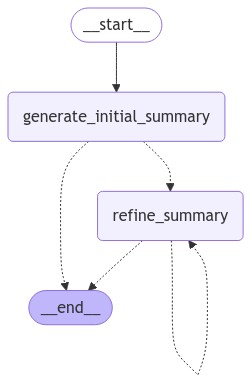

In [8]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [9]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    print(list(step))


['contents']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']
['contents', 'index', 'summary']


In [10]:
display(Markdown(step['summary']))

**Resumo dos Personagens Principais**

* Quincas Borba: um personagem complexo e multifacetado que combina nobreza e humildade. Ele é capaz de expressar orgulho e autoestima, mas também se sente humilde e servil.
* Marcella: uma mulher que morreu no hospital da Ordem Terceira, onde Quincas Borba estava envolvido. Sua morte é um evento trágico que afeta Quincas Borba profundamente.
* Eugenia: a filha de D. Eusebia e do Quincas Borba. Ela é mencionada como uma pessoa coxa e triste, mas sua presença não é significativa no final do livro.

**Resumo dos Capítulos**

* CAPITULO CLIX: O Quincas Borba retorna após seis meses de ausência e apresenta-se em um estado de semi-demência. Ele afirma que queimou o manuscrito completo e está recomeçando a escrever.
* CAPITULO CLX: Este capítulo é todo de negativas, mencionando as faltas do autor (não alcançar a celebridade do emplasto, não ser ministro, etc.) e destacando a boa fortuna de não ter sofrido morte ou semi-demência.

**Resumo Geral**

O livro termina com o Quincas Borba em um estado de semi-demência, queimando o manuscrito completo e recomeçando a escrever. O autor do livro não alcançou a celebridade do emplasto, não foi ministro ou califa, mas conseguiu evitar sofrer morte ou semi-demência. No final, ele se depara com a negativa de ter filhos, um saldo que é uma conclusão triste e reflexiva para o livro.

In [11]:
len(step['summary'])

1372